In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import os, math

import dataloader
from model import *
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

In [2]:
# np.random.seed(231)
# torch.manual_seed(123)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Dataset

In [3]:
import argparse 
fold = 4

parser = argparse.ArgumentParser()
# hyper-parameters
parser.add_argument('--batch_size', type=int, default=8000,
                    help='training batch size')
parser.add_argument('--path_image', type=str, default="./dataset/total_12_folders",
                    help='')
parser.add_argument('--path_clinical_train', type=str, default="./dataset/Lung1dataset/train_fold_{}.csv".format(fold),
                    help='')
parser.add_argument('--path_clinical_val', type=str, default="./dataset/Lung1dataset/val_fold_{}.csv".format(fold),
                    help='')
parser.add_argument('--path_clinical_test', type=str, default="./dataset/Lung1dataset/test.csv",
                    help='')
parser.add_argument('--data_type', type=str, default="clinical",
                    help='Choose one of these options: clinical, ct, pet, clinical_ct_pet')  

parser.add_argument('--dataname', type=str, default="Lung1-dataset",
                            help='Choose one of these options: lungcancer, Lung1-dataset ') 
arg, unknown = parser.parse_known_args()

In [4]:
# X_train, Y_train, E_train, _ = dataloader.load_clinical_data("./dataset/train.csv")
# X_test, Y_test, E_test, patients_test = dataloader.load_clinical_data("./dataset/test.csv")

# X_train = torch.Tensor(X_train).to(device)
# Y_train = torch.Tensor(Y_train).to(device)
# E_train = torch.Tensor(E_train).to(device)

# X_test = torch.Tensor(X_test).to(device)
# Y_test = torch.Tensor(Y_test).to(device)
# E_test = torch.Tensor(E_test).to(device)

# print("X train shape: ", X_train.shape)
# print("Y train shape: ", Y_train.shape)
# print("E train shape: ", E_train.shape)
# print()
# print("X test shape: ", X_test.shape)
# print("Y test shape: ", Y_test.shape)
# print("E test shape: ", E_test.shape)


#for _, _, X, E, Y in dataloader.load_CT_PET_Clinical_data(arg.path_image, arg.path_clinical_train, arg.batch_size, "test", arg.data_type):
for X, Y, E in dataloader.load_data(arg.dataname, arg.path_clinical_train, 'test'):
    X_train = X.to(device)
    Y_train = Y.to(device)#.int() +1
    E_train = E.to(device)
#for _, _, X, E, Y in dataloader.load_CT_PET_Clinical_data(arg.path_image, arg.path_clinical_val, arg.batch_size, "test", arg.data_type):
for X, Y, E in dataloader.load_data(arg.dataname, arg.path_clinical_val, 'test'):
    X_val = X.to(device)
    Y_val = Y.to(device)#.int()+1
    E_val = E.to(device)
#for _, _, X, E, Y in dataloader.load_CT_PET_Clinical_data(arg.path_image, arg.path_clinical_test, arg.batch_size, "test", arg.data_type):
for X, Y, E in dataloader.load_data(arg.dataname, arg.path_clinical_test, 'test'):
    X_test = X.to(device)
    Y_test = Y.to(device)#.int()+1
    E_test = E.to(device)
    
print("X train shape: ", X_train.shape)
print("Y train shape: ", Y_train.shape)
print("E train shape: ", E_train.shape)
print()
print("X val shape: ", X_val.shape)
print("Y val shape: ", Y_val.shape)
print("E val shape: ", E_val.shape)
print()
print("X test shape: ", X_test.shape)
print("Y test shape: ", Y_test.shape)
print("E test shape: ", E_test.shape)


X train shape:  torch.Size([239, 5])
Y train shape:  torch.Size([239])
E train shape:  torch.Size([239])

X val shape:  torch.Size([59, 5])
Y val shape:  torch.Size([59])
E val shape:  torch.Size([59])

X test shape:  torch.Size([100, 5])
Y test shape:  torch.Size([100])
E test shape:  torch.Size([100])


## Training the model
To train the model we need to define an optimizer. You can choose any torch.optim optimizer, but here we instead use one from tt.optim as it has some added functionality. We use the Adam optimizer, but instead of choosing a learning rate, we will use the scheme proposed by Smith 2017 to find a suitable learning rate with model.lr_finder. See this post for an explanation.

In [5]:
#model = torch.load("./checkpoint/2020-12-26_clinical/model_146.pt")
model = torch.load("./checkpoint/2021-02-06_clinical_fold_{}/model_best.pt".format(fold))
model.to(device)
model.eval()

DeepCPH_clinical(
  (linear1): Linear(in_features=5, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=16, out_features=1, bias=False)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=True)
)

In [6]:
def target_to_df(durations, events):
    df = pd.DataFrame({"duration": durations, "event": events}) 
    return df

def partial_log_likelihood(model, input, duration, event, g_preds=None, eps=1e-7):
    '''Calculate the partial log-likelihood for the events in datafram df.
    This likelihood does not sample the controls.
    Note that censored data (non events) does not have a partial log-likelihood.

    Arguments:
        input {tuple, np.ndarray, or torch.tensor} -- Input to net.
        target {tuple, np.ndarray, or torch.tensor} -- Target labels.

    Keyword Arguments:
        g_preds {np.array} -- Predictions from `model.predict` (default: {None})
        batch_size {int} -- Batch size (default: {8224})
        eval_ {bool} -- If 'True', use 'eval' mode on net. (default: {True})
        num_workers {int} -- Number of workers in created dataloader (default: {0})

    Returns:
        Partial log-likelihood.
    '''
    df = target_to_df(duration, event)
    if g_preds is None:
        g_preds = model(input).cpu().detach().numpy()
    return (df
            .assign(_g_preds=g_preds)
            .sort_values("duration", ascending=False)
            .assign(_cum_exp_g=(lambda x: x['_g_preds']
                                .pipe(np.exp)
                                .cumsum()
                                .groupby(x["duration"])
                                .transform('max')))
            .loc[lambda x: x["event"] == 1]
            .assign(pll=lambda x: x['_g_preds'] - np.log(x['_cum_exp_g'] + eps))
            ['pll'])

In [7]:
partial_log_likelihood(model, X_train, Y_train.cpu().detach().numpy(), E_train.cpu().detach().numpy()).mean()

-4.655169

## Prediction
For evaluation we first need to obtain survival estimates for the test set. This can be done with model.predict_surv which returns an array of survival estimates, or with model.predict_surv_df which returns the survival estimates as a dataframe.

However, as CoxPH is semi-parametric, we first need to get the non-parametric baseline hazard estimates with compute_baseline_hazards.

Note that for large datasets the sample argument can be used to estimate the baseline hazard on a subset.

In [8]:
def compute_baseline_hazards(model, input, df_target, max_duration):

    # Here we are computing when expg when there are no events.
    #   Could be made faster, by only computing when there are events.
    return (df_target
            .assign(expg=np.exp(model(input).cpu().detach().numpy()))
            .groupby("duration")
            .agg({'expg': 'sum', "event": 'sum'})
            .sort_index(ascending=False)
            .assign(expg=lambda x: x['expg'].cumsum())
            .pipe(lambda x: x["event"]/x['expg'])
            .fillna(0.)
            .iloc[::-1]
            .loc[lambda x: x.index <= max_duration]
            .rename('baseline_hazards'))
           


In [9]:
df = target_to_df(Y_train.cpu().detach().numpy(), E_train.cpu().detach().numpy()) 
max_duration = np.inf 

base_haz = compute_baseline_hazards(model, X_train, df, max_duration)
base_haz

duration
10.0      0.003245
18.0      0.003261
39.0      0.003291
50.0      0.003307
51.0      0.003319
            ...   
4013.0    0.000000
4019.0    0.000000
4067.0    0.000000
4202.0    0.000000
4208.0    0.000000
Name: baseline_hazards, Length: 226, dtype: float32

In [10]:
bch = (base_haz.cumsum().rename('baseline_cumulative_hazards'))
bch

duration
10.0      0.003245
18.0      0.006506
39.0      0.009797
50.0      0.013104
51.0      0.016423
            ...   
4013.0    2.173827
4019.0    2.173827
4067.0    2.173827
4202.0    2.173827
4208.0    2.173827
Name: baseline_cumulative_hazards, Length: 226, dtype: float32

In [11]:
max_duration = np.inf
bch = bch.loc[lambda x: x.index <= max_duration]

expg=np.exp(model(X_test).cpu().detach().numpy().reshape(1, -1))                                                                                        

surv = np.exp(-pd.DataFrame(bch.values.reshape(-1, 1).dot(expg), index=bch.index))


                 0         1         2         3         4
duration                                                  
10.0      0.996188  0.996696  0.996682  0.996692  0.993259
18.0      0.992372  0.993386  0.993359  0.993379  0.986529
39.0      0.988536  0.990057  0.990016  0.990046  0.979785
50.0      0.984696  0.986723  0.986668  0.986709  0.973054
51.0      0.980858  0.983388  0.983320  0.983371  0.966346
...            ...       ...       ...       ...       ...
4013.0    0.077431  0.108901  0.107910  0.108646  0.010766
4019.0    0.077431  0.108901  0.107910  0.108646  0.010766
4067.0    0.077431  0.108901  0.107910  0.108646  0.010766
4202.0    0.077431  0.108901  0.107910  0.108646  0.010766
4208.0    0.077431  0.108901  0.107910  0.108646  0.010766

[226 rows x 5 columns]


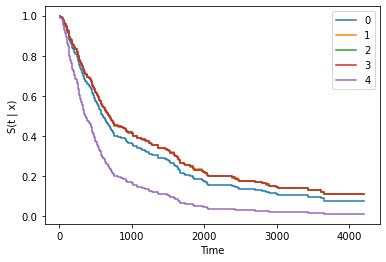

In [12]:
import matplotlib.pyplot as plt
surv.iloc[:, :5].plot(drawstyle='steps-post')  #drawstyle='steps-post'
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')
print(surv.iloc[:, :5])

## Evaluation
We can use the EvalSurv class for evaluation the concordance, brier score and binomial log-likelihood. Setting censor_surv='km' means that we estimate the censoring distribution by Kaplan-Meier on the test set.

In [13]:
from pycox.evaluation import EvalSurv

In [14]:
durations_test, events_test = Y_test.cpu().detach().numpy(), E_test.cpu().detach().numpy()
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

## Concordance Metric

In [15]:
ev.concordance_td()

0.4888564882316184

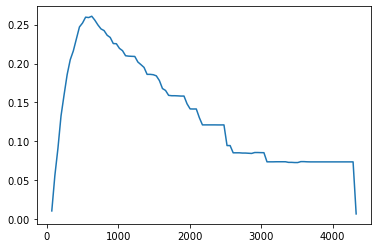

In [16]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
_ = ev.brier_score(time_grid).plot()

In [17]:
ev.integrated_brier_score(time_grid)

0.1362444195285756

In [18]:
ev.integrated_nbll(time_grid)

0.4311074746808886

## MAE Metric


In [19]:
surv=surv.reset_index()

surv["duration"] = surv["duration"]#*7
duration = np.append(np.array([[0]]), np.array(surv["duration"]))
duration = np.append(duration, np.array([[duration.max()+1]]))
surv=surv.set_index("duration")
surv

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
duration,,,,,,,,,,,,,,,,,,,,,
10.0,0.996188,0.996696,0.996682,0.996692,0.993259,0.995788,0.996585,0.994422,0.994255,0.995306,...,0.996433,0.996276,0.996679,0.996452,0.996385,0.993268,0.996139,0.996114,0.996805,0.995779
18.0,0.992372,0.993386,0.993359,0.993379,0.986529,0.991573,0.993165,0.988848,0.988514,0.990611,...,0.992861,0.992548,0.993352,0.992899,0.992766,0.986548,0.992273,0.992223,0.993604,0.991555
39.0,0.988536,0.990057,0.990016,0.990046,0.979785,0.987338,0.989726,0.983254,0.982754,0.985896,...,0.989269,0.988799,0.990006,0.989327,0.989126,0.979813,0.988388,0.988313,0.990385,0.987310
50.0,0.984696,0.986723,0.986668,0.986709,0.973054,0.983100,0.986282,0.977665,0.976999,0.981180,...,0.985672,0.985047,0.986654,0.985749,0.985482,0.973091,0.984498,0.984398,0.987160,0.983063
51.0,0.980858,0.983388,0.983320,0.983371,0.966346,0.978865,0.982837,0.972088,0.971259,0.976471,...,0.982076,0.981295,0.983303,0.982173,0.981839,0.966392,0.980611,0.980486,0.983934,0.978819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4013.0,0.077431,0.108901,0.107910,0.108646,0.010766,0.059159,0.101118,0.023585,0.021066,0.042778,...,0.091264,0.082141,0.107657,0.092455,0.088391,0.010835,0.074892,0.073644,0.117208,0.058792
4019.0,0.077431,0.108901,0.107910,0.108646,0.010766,0.059159,0.101118,0.023585,0.021066,0.042778,...,0.091264,0.082141,0.107657,0.092455,0.088391,0.010835,0.074892,0.073644,0.117208,0.058792
4067.0,0.077431,0.108901,0.107910,0.108646,0.010766,0.059159,0.101118,0.023585,0.021066,0.042778,...,0.091264,0.082141,0.107657,0.092455,0.088391,0.010835,0.074892,0.073644,0.117208,0.058792


In [20]:
import matplotlib.pyplot as plt
from scipy import interpolate

predicted_survival_MRL, predicted_survival_MedianLife = [], []
for idx in range(len(Y_test)):#
    S = np.append(np.array([[1]]), np.array(surv[idx]))
    S = np.append(S, np.array([[0]]))
    f = interpolate.interp1d(duration, S) # x, y
    xnew = np.arange(0, duration.max(), 1)
    ynew = f(xnew)   # use interpolation function returned by `interp1d`
    sum_ = 0
    for i in range(len(xnew)-1):
        sum_ += ynew[i]  #ynew[i] = ynew[i]*(xnew[i+1] - xnew[i]) due to xnew[i+1] - xnew[i] = 1
        
    predicted_survival_MRL.append(sum_)
    
    # Median life
    dis = abs(ynew - 0.5)
    time = np.where(dis == dis.min())[0][0]
    predicted_survival_MedianLife.append(time)
    #print(patients_test[idx], sum_)

predicted_survival_MRL = np.asarray(predicted_survival_MRL)
predicted_survival_MedianLife = np.asarray(predicted_survival_MedianLife)

print("Mean Residual Life: ", np.mean(abs(predicted_survival_MRL.reshape(-1)-durations_test)[events_test==1]))
print("Median Life: ", np.mean(abs(predicted_survival_MedianLife.reshape(-1)-durations_test)[events_test==1]))



Mean Residual Life:  680.1672666522444
Median Life:  502.39325842696627


## KM Plot 
1. Mean residual Life

<AxesSubplot:xlabel='timeline'>

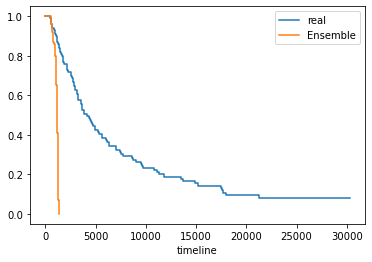

In [21]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

ax = plt.subplot(111)

kmf.fit(durations_test*7, event_observed=events_test, label='real')
kmf.plot(ax=ax, ci_show=False)

kmf.fit(predicted_survival_MRL, event_observed=events_test, label='Ensemble')
kmf.plot(ax=ax, ci_show=False)

2. Median Life

<AxesSubplot:xlabel='timeline'>

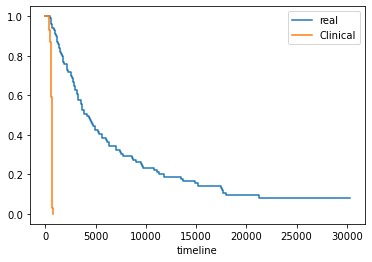

In [22]:
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

ax = plt.subplot(111)

kmf.fit(durations_test*7, event_observed=events_test, label='real')
kmf.plot(ax=ax, ci_show=False)

kmf.fit(predicted_survival_MedianLife, event_observed=events_test, label='Clinical')
kmf.plot(ax=ax, ci_show=False)

In [23]:
# # np.random.seed(231)
# # torch.manual_seed(123)


# class MAE(nn.Module):
#     def __init__(self):
#         super(MAE, self).__init__()
#     def forward(self, y_true, y_pred):
#         loss = abs(y_true - y_pred).sum() / y_true.shape[0]
#         return loss  

# #"""model"""
# class Distribution_network(nn.Module):
#     def __init__(self):
#         super(Distribution_network, self).__init__()
#         # self.histology = nn.Linear(4, 1, bias=True)
#         # self.gender  = nn.Linear(2, 1, bias=True) 
  
#         self.linear1 = nn.Linear(7, 64, bias=True)
#         self.bn1 = nn.BatchNorm1d(num_features=64)
#         self.linear2 = nn.Linear(64, 16, bias=True)
#         self.bn2 = nn.BatchNorm1d(num_features=16)
#         self.linear3 = nn.Linear(16, 1, bias=False)
#         self.relu    = nn.ReLU()
#         self.dropout = nn.Dropout(p=0.1, inplace=True)

#         self.reset_parameters()
    
#     def reset_parameters(self):
#         for m in self.modules():
#             if isinstance(m, nn.Conv3d):
#                 nn.init.kaiming_normal_(m.weight,
#                                         mode='fan_out',
#                                         nonlinearity='relu')
#             elif isinstance(m, nn.BatchNorm3d):
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 0)

#     def forward(self, X_clinical):
#         # history = self.histology(X_clinical[:, :4])
#         # gender = self.gender(X_clinical[:, 4:6])
#         # out = torch.cat((history, gender, X_clinical[:, 6:]), dim=1)

#         out = X_clinical[:, 6:]

#         out = self.linear1(out)
#         out = self.bn1(out)
#         out = self.relu(out)
#         out = self.dropout(out)

#         out = self.linear2(out)
#         out = self.bn2(out)
#         out = self.relu(out)
#         out = self.dropout(out)

#         out = self.linear3(out)
#         return out
    
# survival_model = Distribution_network()
# survival_model.to(device)
# #optimizer = torch.optim.Adam(survival_model.parameters(), lr=0.00001)
# optimizer = torch.optim.RMSprop(survival_model.parameters(), lr=0.01, alpha=0.99, eps=1e-08)
# criterion = MAE()

In [24]:
# model.eval()
# min_mae = np.inf

# #predict
# with torch.no_grad():
#     hr_exp_pred = model(X_train)[0].exp()

# # train Distribution function network
# for epoch in range(100):#1715
#     survival_model.train()
#     optimizer.zero_grad()
#     y_pred = survival_model(X_train) / hr_exp_pred
#     loss = criterion(Y_train[E_train==1], y_pred[E_train==1])
#     loss.backward()
#     optimizer.step()
#     if (epoch +1) % 10 == 0:
#         print(epoch, (loss/E_train.sum()).item())


In [25]:
# """predict"""

# model.eval()
# with torch.no_grad():
#     hr_exp_pred = model(X_test)[0].exp()

    
# """predict"""
# survival_model.eval()
# with torch.no_grad():
#     predicted_survival = survival_model(X_test) / hr_exp_pred
#     predicted_survival = predicted_survival.reshape(-1)
#     mae = abs(predicted_survival-Y_test)[E_test==1].mean()
#     print(mae, mae*7)


In [26]:
# predicted_survival.shape, Y_test[E_test==1].shape

In [27]:
# import matplotlib.pyplot as plt
# from lifelines import KaplanMeierFitter

# kmf = KaplanMeierFitter()

# ax = plt.subplot(111)

# kmf.fit(durations_test*7, event_observed=events_test, label='real')
# kmf.plot(ax=ax, ci_show=False)

# kmf.fit((predicted_survival*7).cpu().detach().numpy(), event_observed=events_test, label='Ensemble')
# kmf.plot(ax=ax, ci_show=False)

## Overall Stage Analysis

In [28]:
# #X_test[:, 8] # -1.5518, -0.7397,  0.8846,  0.0725,
# overallStage = X_test[:, 8].cpu().detach().numpy()
# overallStage[ overallStage  < -1] = 1 
# overallStage = overallStage * events_test
# stage1 = (abs(predicted_survival-Y_test)[overallStage==1].mean()*7).cpu().detach().numpy()
# print(len(abs(predicted_survival-Y_test)[overallStage==1]))

# overallStage = X_test[:, 8].cpu().detach().numpy()
# overallStage[ overallStage  < -1] = 0
# overallStage[ overallStage < 0] = 1 
# overallStage = overallStage * events_test
# stage2 =  (abs(predicted_survival-Y_test)[overallStage==1].mean()*7).cpu().detach().numpy()
# print(len(abs(predicted_survival-Y_test)[overallStage==1]))

# overallStage = X_test[:, 8].cpu().detach().numpy()
# overallStage[ overallStage  < 0] = 0
# overallStage[ overallStage > 0.5] = 0
# overallStage[ overallStage > 0] = 1
# overallStage = overallStage * events_test
# stage3 = (abs(predicted_survival-Y_test)[overallStage==1].mean()*7).cpu().detach().numpy()
# print(len(abs(predicted_survival-Y_test)[overallStage==1]))

# overallStage = X_test[:, 8].cpu().detach().numpy()
# overallStage[ overallStage  > 0.5] = 1
# # overallStage = overallStage * events_test
# stage4 = (abs(predicted_survival-Y_test)[overallStage==1].mean()*7).cpu().detach().numpy()
# print(len(abs(predicted_survival-Y_test)[overallStage==1]))

# print(stage1, stage2, stage3, stage4)

In [29]:
# overallStage = X_test[:, 8].cpu().detach().numpy()
# overallStage[ overallStage  < -1] = 1 
# overallStage = overallStage * events_test
# stage1 = (abs(predicted_survival-Y_test)[overallStage==1].mean()*7).cpu().detach().numpy()
# print(len(abs(predicted_survival-Y_test)[overallStage==1]))

# overallStage = X_test[:, 8].cpu().detach().numpy()
# overallStage[ overallStage  < -1] = 0
# overallStage[ overallStage < 0] = 1 
# overallStage = overallStage * events_test
# stage2 =  (abs(predicted_survival-Y_test)[overallStage==1].mean()*7).cpu().detach().numpy()
# print(len(abs(predicted_survival-Y_test)[overallStage==1]))

# overallStage = X_test[:, 8].cpu().detach().numpy()
# overallStage[ overallStage  < 0] = 0
# overallStage[ overallStage > 0.5] = 0
# overallStage[ overallStage > 0] = 1
# overallStage = overallStage * events_test
# stage3 = (abs(predicted_survival-Y_test)[overallStage==1].mean()*7).cpu().detach().numpy()
# print(len(abs(predicted_survival-Y_test)[overallStage==1]))

# overallStage = X_test[:, 8].cpu().detach().numpy()
# overallStage[ overallStage  > 0.5] = 1
# overallStage = overallStage * events_test
# stage4 = (abs(predicted_survival-Y_test)[overallStage==1].mean()*7).cpu().detach().numpy()
# print(len(abs(predicted_survival-Y_test)[overallStage==1]))

# print(stage1, stage2, stage3, stage4)

## Classification

In [30]:
predicted_survival_MedianLife = predicted_survival_MedianLife[events_test==1]
durations_test = durations_test[events_test==1]

Y_target_cate = np.zeros_like(durations_test)
Y_pred_cate   = np.zeros_like(Y_target_cate)

Y_target_cate[durations_test*7 >= 4*365] = 2
Y_target_cate[durations_test*7 < 4*365] = 1
Y_target_cate[durations_test*7 < 2*365] = 0

Y_pred_cate[predicted_survival_MedianLife >= 4*365] = 2
Y_pred_cate[predicted_survival_MedianLife < 4*365] = 1
Y_pred_cate[predicted_survival_MedianLife < 2*365] = 0

In [31]:
count = np.zeros((3,3))
for i in range(len(Y_target_cate)):
    count[int(Y_pred_cate[i]), int(Y_target_cate[i])] += 1
count

array([[ 6., 11., 72.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [32]:
(count[0,0] + count[1,1]+count[2,2])/count.sum()

0.06741573033707865

0.19101123595505617

In [34]:
538-count.sum()

449.0